# Link Robot Arm Kinematics Tutorial

Learning Outcomes:
- How to use mujoco: a common robotics simulator
- Basic Robot Kinematics (forward kinematics, inverse kinematics)
- Basic Robot Control (PD control)





## Getting Started

We'll be using OpenAI gymnasium to model the robot's environment.
- [OpenAI gymnasium](https://gymnasium.farama.org) is a toolkit for developing planning and control algorithms. It provides a standard API that abstracts away the model of the robot's environment. It is primarily used for reinforcement learning agents, but can work with any controller, including the PD controllers you'll build in this assignment.
  - If you've never used gym, be sure to read this short [tutorial](https://gym.openai.com/docs/) before getting started.


## Installation Instructions
Before running this notebook, you'll need to install `gymnasium`

In [1]:
%pip install gymnasium[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 7.9 MB/s eta 0:00:00


In [2]:
#@title Check if installation was successful + Setup mujoco

from google.colab import files

import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.4 MB/s eta 0:00:00


### Reacher Environment Introduction

The robot arm you will be controlling looks like this:

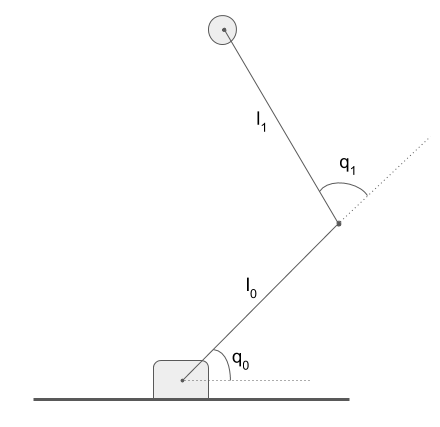

The base of the robot is at the origin; the links $l_0$ and $l_1$ are 0.1 and 0.11 units long respectively.

The action space of environment is [$\tau_0$,$\tau_1$], where $\tau_0$ and $\tau_1$ are the torques applied to joints $q_0$ and $q_1$ respectively.

In [4]:
# load libraries (if this fails, see "Installation Instructions")
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

""

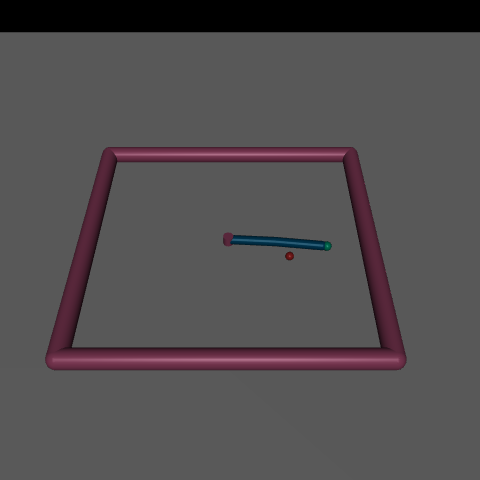

In [5]:
# initialize the environment
env = gym.make("Reacher-v4",render_mode="rgb_array")

observation, info = env.reset()
media.show_image(env.render())

Your job is to implement PD controllers that track the trajectory

$$\begin{bmatrix}x(\theta) \\ y(\theta)\end{bmatrix}
= \begin{bmatrix}(0.19 + 0.02 \cos 4\theta)\cos\theta \\ (0.19 + 0.02 \cos 4\theta)\sin\theta\end{bmatrix},
\text{ for }\theta \in [-\pi, \pi]$$

This trajectory is plotted below:

(-0.21, -2.5717582782094416e-17)


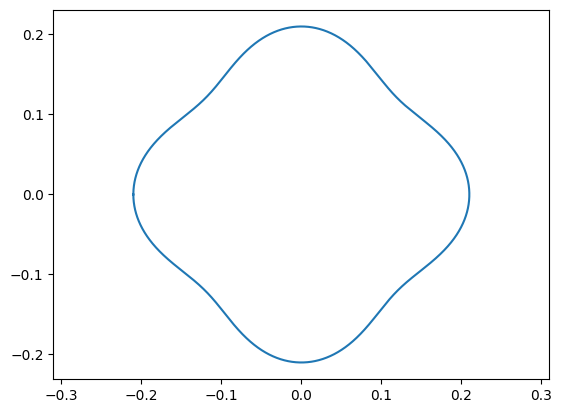

In [6]:
x = [(0.19 + 0.02 * np.cos(theta * 4)) * np.cos(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
y = [(0.19 + 0.02 * np.cos(theta * 4)) * np.sin(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
plt.plot(x, y)
plt.axis('equal')
# plt.show()
plt.savefig('arm_traj.png')
traj = list(zip(x,y))
print(traj[0])

## Cartesian Controller

### 1. Forward Model

Derive the forward model for the robot as a closed-form expression expressed in joint angles and link length:

$$f\left(\begin{bmatrix}q_0 \\ q_1\end{bmatrix}\right) =
\begin{bmatrix}
% your answer here
\underline{\;\;\;\;} \\
\underline{\;\;\;\;}
\end{bmatrix}
= \begin{bmatrix} x \\ y\end{bmatrix}$$

Using the robot model parameters, write a function `getForwardModel` that takes the joint states and returns the end-effector position.

In [7]:
l0 = 0.1
l1 = 0.11
def getForwardModel(q0, q1):
    x = (np.cos(q0) * l0) + (np.cos(q1 + q0) * l1)
    y = (np.sin(q0) * l0) + (np.sin(q1 + q0) * l1)
    return np.array([x,y])

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_state` for environment variables or `env.get_wrapper_attr('set_state')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.data to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.data` for environment variables or `env.get_wrapper_attr('data')` that will search the reminding wrappers.
  logger.warn(


""

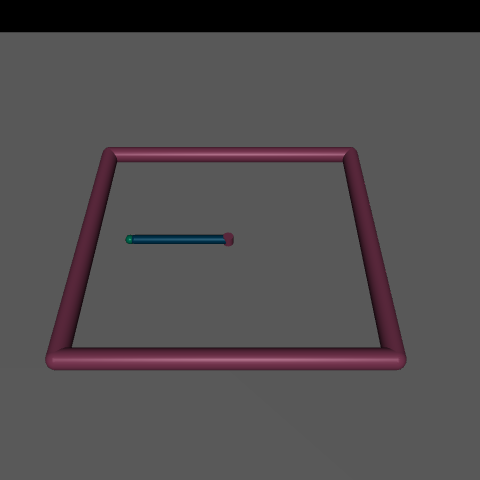

In [8]:
# resets env
obs, info = env.reset()
q0,q1 = np.pi,0

# sets initial state of env
env.set_state(np.array([q0,q1,0,0]),np.array([0,0,0,0]))
q0, q1 = env.data.qpos[:2]
xy = getForwardModel(q0,q1) # predicted xy from forward model

torq = np.array([0,0])
obs = env.step(torq)

xy_exp = obs[0][8:-1] # get actual xy
assert np.allclose(xy_exp,xy)

media.show_image(env.render())

### 2. Jacobian

Derive the expression for the Jacobian of the robot:

$$J_f(q_0, q_1) = \begin{bmatrix}
\underline{\;\;\;\;} % your answer here
\end{bmatrix}$$

Write a function `getJacobian` that takes the joint states and returns the Jacobian.

In [11]:
def getJacobian(q0, q1):

    jacX_q0 = -l1 * np.sin(q0 + q1) - l0 * np.sin(q0)
    jacY_q0 = l1 * np.cos(q0 + q1) + l0 * np.cos(q0)

    jacX_q1 = - l1 * np.sin(q0 + q1)
    jacY_q1 = l1 * np.cos(q0 + q1)
    # jacX = 2 ** X
    # jacX = l0 * np.cos(-q1)
    # jaxY = l0 * np.sin(-q1)
    # jac = np.cos(q1) - q0(np.sin(q1) * np.sin(q1))(np.cos(q1))

    return np.array([[jacX_q0, jacX_q1], [jacY_q0, jacY_q1]])

### 3. X-Y Controller

**Background:** for reasons beyond the scope of this course, it so happens that, for any robot,
$$\vec \tau = J^T \vec F,$$
where
- $\vec F = \langle F_x, F_y \rangle$ is the force vector exerted by the robot at the end effector
- $\vec \tau = \langle \tau_0, \tau_1 \rangle$ is the vector of torques exerted by the joints
- $J$ is the Jacobian matrix at the current position.

Use this fact to implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the end-effector as the input signal. Your controller should compute forces $F_x$ and $F_y$, and then use `getJacobian` along with the above equation to translate them into joint torques.

Plot the trajectory of the robot juxtaposed over the desired trajectory, and calculate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

#### PD Controller Explanation

##### Introduction
A Proportional-Derivative (PD) controller is used in control systems to regulate the output by considering both the present and the future error between the desired and actual system states.

##### Mathematical Formulation
The control input $u(t)$ of a PD controller is given by:

$$
u(t) = K_p \cdot e(t) + K_d \cdot \frac{d}{dt}e(t)
$$

where:

- $u(t)$ is the control input at time $t$.
- $K_p$ is the proportional gain.
- $K_d$ is the derivative gain.
- $e(t)$ is the error at time $t$, defined as $e(t) = \text{Setpoint} - \text{Process Value}$.
- $\frac{d}{dt}e(t)$ is the rate of change of error with respect to time.

##### Proportional Control ($K_p$)
The proportional term produces an output value that is proportional to the error $e(t)$. The proportional response can be adjusted by multiplying the error by a constant $K_p$.

##### Derivative Control ($K_d$)
The derivative term anticipates future error by considering its rate of change. It provides a control output to counteract the rate of error change.

##### Advantages
The PD controller combines the advantages of both Proportional and Derivative control actions, making the system more stable and quicker to reach the setpoint without introducing integral action, which can lead to overshoot.


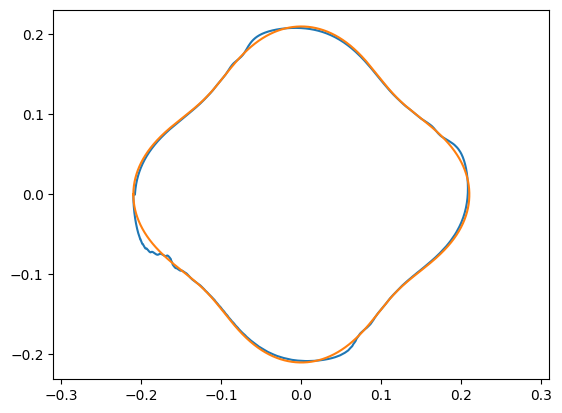

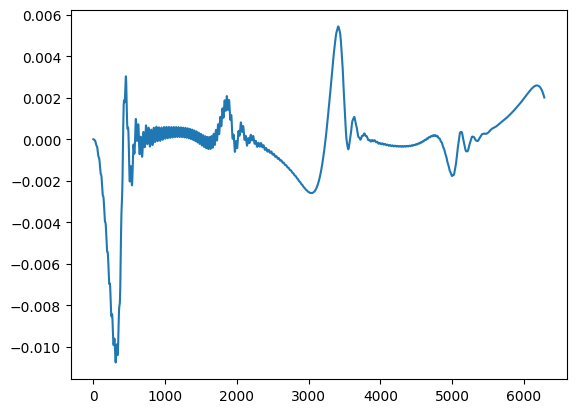

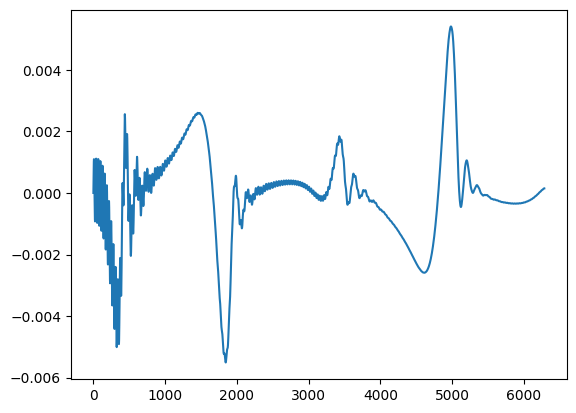

MSE_x: 4.0456356661235155e-06
MSE_y: 2.4244501258469657e-06
MSE: 6.470085791970481e-06


In [12]:
q0,q1 = np.pi,0

curr_plt = np.zeros((len(traj),2))

# resets env
obs, info = env.reset()

# sets initial state of env
env.set_state(np.array([q0,q1,0,0]),np.array([0,0,0,0]))

# frames for video
frames = []

prev_error = (0,0)

for t in range(len(traj)):
    q0, q1 = env.data.qpos[:2] # current joint angles
    xy = getForwardModel(q0,q1) # current eef position
    #CODE HERE
    #PID controller that uses polynomial function (used in cars for acceleromters)
    #Running cruise controller in car

    #kp and kb (constants shifts how strongly or softly it affects certain part)

    kp = (10, 10)
    kd = (0.1, 0.1)

    error_x = traj[t][0] - xy[0]
    error_y = traj[t][1] - xy[1]
    error = (error_x, error_y)

    force = np.array([0,0]) # cartesian force: <Fx, Fy> replace with PD controller output
    force_x = kp[0] * error_x + kd[0] * (error_x - prev_error[0])
    force_y = kp[1] * error_y + kd[1] * (error_y - prev_error[1])
    prev_error = (error_x, error_y)


    # force_vector = (force_x, force_y)
    jacobian = getJacobian(q0, q1)

    force = np.array([force_x, force_y])

    torque = np.matmul(np.transpose(jacobian), force)


    tau = torque # joint torques: <tau_0, tau_1>

    env.step(tau) # step with action
    curr_plt[t] = xy # adds current position to list for display
    #frames.append(env.render()) # rendering

#duration = 3.8  # (seconds)
#framerate = 60  # (Hz)
#media.show_video(frames, fps=framerate)

plt.axis('equal')
plt.plot(curr_plt[:,0],curr_plt[:,1])
plt.plot(x,y)
plt.show()

t = np.arange(len(traj))
err_x = curr_plt[:,0] - x
err_y = curr_plt[:,1] - y
plt.plot(t,err_x)
plt.show()

plt.plot(t,err_y)
plt.show()
mse_x = (err_x ** 2).mean(axis=None)
mse_y = (err_y ** 2).mean(axis=None)
print("MSE_x: {}".format(mse_x))
print("MSE_y: {}".format(mse_y))
print("MSE: {}".format(mse_y + mse_x))

## IK Controller

### 4. Inverse Kinematics

#### Jacobian-Based Inverse Kinematics

##### Introduction
Jacobian-based inverse kinematics aims to find the joint angles in a robot manipulator that result in a specific end-effector position. It iteratively refines the joint angles using the Jacobian matrix to minimize the error between the current and target end-effector positions.

##### Algorithm Overview
The code snippet employs an iterative approach to find the joint angles `q` that minimize the error `err` between the end-effector's current and target positions. The algorithm uses the pseudo-inverse of the Jacobian matrix `J` to adjust `q`.

##### Variables

- `err`: Error term, initialized to $\infty$.
- `q`: Current joint angles.
- `eps`: Error tolerance.
- `d_x`: Deviation of the end-effector's current position from the target.
- `J`: Jacobian matrix, calculated from `q`.
- `pseudo_inv`: Pseudo-inverse of `J`.
- `q_err`: Change in `q` to minimize `err`.
- `max_iter`: Maximum number of iterations.

##### Steps

1. **Initialization**: Initialize `err` to $\infty$, `q` to `current_state`, and `eps` to a small value (0.001).

2. **Iteration Loop**: Iterate until `err` is smaller than `eps` or maximum iterations reached (`max_iter`).
    - Calculate the deviation `d_x` between the current end-effector position and the target.
    - Compute the Jacobian matrix `J`.
    - **Singularity Handling**: If $\text{det}(J) < \text{eps}$, slightly perturb `q` and recalculate `J`.
    - Calculate the pseudo-inverse `pseudo_inv` of `J`.
    - Compute the change `q_err` needed in `q` to reduce `err`.
    - Update `q` by subtracting `q_err`.
    - Update `err` as the norm of `q_err`.

3. **Result**: Return the final joint angles `q`.



Using the functions `getForwardModel` and `getJacobian` from parts 1 and 2, write a function `getIK` that takes the current end-effector position, target end-effector position, and current joint states; and returns the target joint-states.

In [14]:
def getIK(target_position, current_state): # this will be used for robot manipulation right now we are hardcoding it more (lot of these things are implemented in packages already so in the future youc an easily call methods to then just call these collaborations)
    q = getForwardModel(current_state)
    err = np.inf
    iteration = 0
    max_iteration = 50
    count = 0
    eps = 0.001

    while err > eps and iteration < max_iteration:
        current_position = getForwardModel(q)

        J = getJacobian(q) # the jacobian matrix

        d_x = target_position - current_position
        if (np.det[J] < eps) :
            q += 0.001
            J = getJacobian(q)
            # break;

        dq = np.linalg.pinv(J)
        q_err = np.linalg.norm(error)
        # q_err = q - err
        q += q_err

        # d_x = err * current_state
        # dq = np.linalg.pinv(J)
        # q += d_x

        count += 1
        iteration = count

    return q

### 5. IK controller

Implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the joint-angles as the input signal.

Plot the trajectory of the robot juxtaposed over the actual trajectory and caluclate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

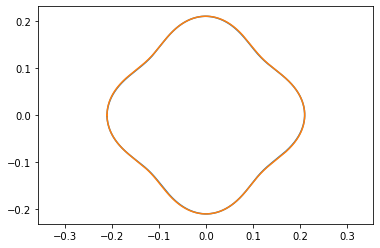

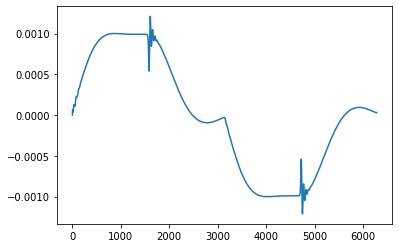

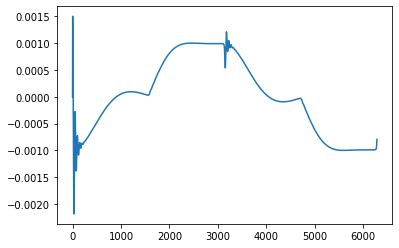

MSE_x: 4.943257982300102e-07
MSE_y: 5.028134490265526e-07
MSE: 9.971392472565628e-07


In [ ]:
# Write your script here.

q0,q1 = np.pi,0

curr_plt = np.zeros((len(traj),2))

# resets env
obs, info = env.reset()

# sets initial state of env
env.set_state(np.array([q0,q1,0,0]),np.array([0,0,0,0]))

# frames for video
frames = []

for t in range(len(traj)):
    q0, q1 = env.data.qpos[:2] # current joint angles
    desired_xy = traj[t]
    kp = 100.0  # setting a proportional gain
    kd = 20.0   # setting derivative gain

    # Current joint angles
    theta0 = q0
    theta1 = q1
    current_xy = getForwardModel([theta0, theta1])
    error = desired_xy - current_xy
    error_dot = (error - prev_error)
    tau0 = kp * error[0] + kd * error_dot[0]
    tau1 = kp * error[1] + kd * error_dot[1]
    tau = np.array([tau0, tau1])
    prev_error = error

    tau = np.array([0,0]) # joint torques: <Tau_0, Tau_1> replace with PD controller output
    env.step(torq) # step with action
    curr_plt[t] = xy # adds current position to list for display
    frames.append(env.render()) # rendering

duration = 3.8  # (seconds)
framerate = 60  # (Hz)
media.show_video(frames, fps=framerate)

plt.axis('equal')
plt.plot(curr_plt[:,0],curr_plt[:,1])
plt.plot(x,y)
plt.show()

t = np.arange(len(traj))
err_x = curr_plt[:,0] - x
err_y = curr_plt[:,1] - y
plt.plot(t,err_x)
plt.show()

plt.plot(t,err_y)
plt.show()
mse_x = (err_x ** 2).mean(axis=None)
mse_y = (err_y ** 2).mean(axis=None)
print("MSE_x: {}".format(mse_x))
print("MSE_y: {}".format(mse_y))
print("MSE: {}".format(mse_y + mse_x))